In [ ]:
import numpy as np 
import cv2
import os
import matplotlib.pyplot as plt

import torchvision, torch
from torchsummary import summary
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
"""
A custom training set was made using existing image datasets.
To maintain the distribution of the dataset, the 

In [ ]:
!unzip /content/drive/MyDrive/Image\ Colorizer/Images/bgr.zip

Streaming output truncated to the last 5000 lines.
  inflating: bgr/004310.jpg          
  inflating: bgr/004314.jpg          
  inflating: bgr/004316.jpg          
  inflating: bgr/004319.jpg          
  inflating: bgr/004329.jpg          
  inflating: bgr/004348.jpg          
  inflating: bgr/004378.jpg          
  inflating: bgr/004394.jpg          
  inflating: bgr/004422.jpg          
  inflating: bgr/004432.jpg          
  inflating: bgr/004459.jpg          
  inflating: bgr/004465.jpg          
  inflating: bgr/004480.jpg          
  inflating: bgr/004488.jpg          
  inflating: bgr/004504.jpg          
  inflating: bgr/004516.jpg          
  inflating: bgr/004540.jpg          
  inflating: bgr/004547.jpg          
  inflating: bgr/004560.jpg          
  inflating: bgr/004579.jpg          
  inflating: bgr/004593.jpg          
  inflating: bgr/004604.jpg          
  inflating: bgr/004610.jpg          
  inflating: bgr/004615.jpg          
  inflating: bgr/004647.jpg          

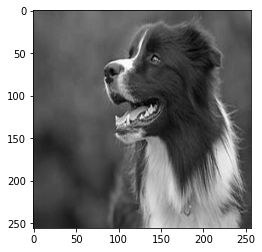

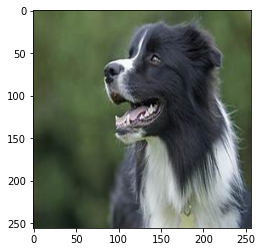

In [ ]:
def get_grayscale(path):

    img = cv2.imread(path, 0)
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
    img = img.reshape(256, 256, 1).astype(float) /255.0
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img


def lab2rgb(img):

    l,a,b = cv2.split(img)
    l = l*100.0
    a = a*255.0 - 128
    b = b*255.0 - 128
    lab = cv2.merge([l,a,b])
    rgb = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
    return rgb


In [ ]:
def get_ab(path):
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
    img = img.reshape(256, 256, 3).astype(float) / 255.0
    img = img[:,:,1:]
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img

# get_ab('bgr/000000.jpg')

In [ ]:
class ImagesDatasetTrain(Dataset):

    def __init__(self, img_dir, transform = []):
        
        self.img_dir = img_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):

        self.path = os.path.join(self.img_dir, self.img_files[idx])
        x = get_grayscale(self.path)
        y = get_ab(self.path)

        return x,y
        

In [ ]:
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
    
        def encode_layer(inp, out, kernel = 3, stride = 1, padding = 0, dilation = 1):
            return nn.Sequential(
                nn.Conv2d(inp, out, kernel, stride, padding, dilation),
                nn.BatchNorm2d(out),
                nn.SELU(True)
            )

        def decode_layer(inp, out, kernel = 3, stride = 1, padding = 0):
            return nn.Sequential(
                nn.ConvTranspose2d(inp, out, kernel, stride, padding),
                nn.BatchNorm2d(out),
                nn.SELU(True)
            )
        
        self.encoder = nn.Sequential(
            encode_layer(1, 64),
            encode_layer(64, 64),
            encode_layer(64, 128),
            encode_layer(128, 256),
            encode_layer(256, 512)
        )

        self.decoder = nn.Sequential(
            decode_layer(512, 256),
            decode_layer(256, 128),
            decode_layer(128, 64),
            decode_layer(64, 32),
            decode_layer(32, 2)
        )

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
class ColorNetLoss(nn.Module):
    def __init__(self):
        super(ColorNetLoss, self).__init__()
        self.l2 = nn.MSELoss()

    def forward(self, x, y):
        return self.l2(x, y)**0.5

In [ ]:
model = ColorNet().to(device)
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]             640
       BatchNorm2d-2         [-1, 64, 254, 254]             128
              SELU-3         [-1, 64, 254, 254]               0
            Conv2d-4         [-1, 64, 252, 252]          36,928
       BatchNorm2d-5         [-1, 64, 252, 252]             128
              SELU-6         [-1, 64, 252, 252]               0
            Conv2d-7        [-1, 128, 250, 250]          73,856
       BatchNorm2d-8        [-1, 128, 250, 250]             256
              SELU-9        [-1, 128, 250, 250]               0
           Conv2d-10        [-1, 256, 248, 248]         295,168
      BatchNorm2d-11        [-1, 256, 248, 248]             512
             SELU-12        [-1, 256, 248, 248]               0
           Conv2d-13        [-1, 512, 246, 246]       1,180,160
      BatchNorm2d-14        [-1, 512, 2

In [ ]:
PATH = '/content/drive/MyDrive/Image Colorizer/modelv2.pth'
model = ColorNet().to(device)
model.load_state_dict(torch.load(PATH))
# model.eval()

ColorNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, mo

In [ ]:
OPTIMIZER = torch.optim.Adam(model.parameters(), lr = 0.001)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, 'min', patience=2, verbose = True)
LOSS = ColorNetLoss()
DATASET = ImagesDatasetTrain('bgr')
LOADER = DataLoader(DATASET, batch_size=8, num_workers=10, shuffle=True)

if torch.cuda.is_available():
    model.cuda()
    torch.backends.cudnn.benchmark = True

running_loss = 0 
pbar = tqdm(range(1, 15), desc = 'Training', position = 1)

for epoch in pbar:

    epoch_loss = 0
    for i, (gray, ab) in enumerate(tqdm(LOADER, desc = f'Epoch {epoch}', position = 1)):

    
        gray = gray.to(device)
        ab = ab.to(device)

        with torch.set_grad_enabled(True):    
            OPTIMIZER.zero_grad()
            pred = model(gray)
            loss = LOSS(pred, ab)
            loss.backward()
            SCHEDULER.step(loss)

        running_loss += loss.item()
        epoch_loss +=  loss.item()

        if ((i + 1) % 100) == 0:
            print("Running Loss: " + str(running_loss), end="; ")
            torch.save(model.state_dict(), '/content/drive/MyDrive/Image Colorizer/'+'modelv2.pth')
            running_loss = 0
    
    epoch_loss = epoch_loss
    print('Epoch Loss: {}'.format(epoch_loss))
    torch.save(model.state_dict(), '/content/drive/MyDrive/Image Colorizer/'+'modelv2.pth')

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
Epoch    11: reducing learning rate of group 0 to 1.0000e-06.
Epoch    14: reducing learning rate of group 0 to 1.0000e-07.
Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
Running Loss: 6.274314407259226; Running Loss: 12.490913517773151; Running Loss: 18.80349224805832; Running Loss: 25.025832924991846; Running Loss: 31.313933826982975; Running Loss: 37.59884447231889; Running Loss: 43.881703186780214; Running Loss: 50.225770980119705; Running Loss: 56.537621799856424; Running Loss: 62.706698413938284; Running Loss: 69.10394359007478; Running Loss: 75.49011701717973; Running Loss: 81.88657012209296; Running Loss: 88.30784210562706; 
Epoch Loss: 0.06310983652280372


Running Loss: 96.04596698656678; Running Loss: 102.37593352049589; Running Loss: 108.6933031566441; Running Loss: 114.96291691064835; Running Loss: 121.2278982065618; Running Loss: 127.44332551211119; Running Loss: 133.70682718604803; Running Loss: 139.87662855535746; Running Loss: 146.2551635056734; Running Loss: 152.7201372422278; Running Loss: 159.15764943882823; Running Loss: 165.4581461623311; Running Loss: 171.8604728989303; Running Loss: 178.14291322603822; 
Epoch Loss: 0.063129685853158


Running Loss: 186.10278487950563; Running Loss: 192.4147515743971; Running Loss: 198.73834265396; Running Loss: 204.92810635268688; Running Loss: 211.40880360081792; Running Loss: 217.56345030665398; Running Loss: 223.6734156832099; Running Loss: 229.79573727026582; Running Loss: 236.13923824951053; Running Loss: 242.65134831517935; Running Loss: 248.84264022484422; Running Loss: 255.10121705383062; Running Loss: 261.5457326583564; Running Loss: 267.9601897485554; 
Epoch Loss: 0.06310931452434887


Running Loss: 276.0185560248792; Running Loss: 282.47174244746566; Running Loss: 288.7038302384317; Running Loss: 294.879068210721; Running Loss: 301.3908272087574; Running Loss: 307.62132616341114; Running Loss: 313.96820045262575; Running Loss: 320.14930779859424; Running Loss: 326.34860721603036; Running Loss: 332.6802494712174; Running Loss: 338.85410348698497; Running Loss: 345.10995243117213; Running Loss: 351.5737749636173; Running Loss: 357.83178946748376; 
Epoch Loss: 0.06307699546228383


Running Loss: 365.7680179513991; Running Loss: 371.8259499594569; Running Loss: 378.1099793985486; Running Loss: 384.47607845813036; Running Loss: 390.8726787120104; Running Loss: 397.22980710864067; Running Loss: 403.326684396714; Running Loss: 409.6758404187858; Running Loss: 416.04638328030705; Running Loss: 422.4015646800399; Running Loss: 428.6362158320844; Running Loss: 435.0307752378285; Running Loss: 441.45631251856685; Running Loss: 447.8009096086025; 
Epoch Loss: 0.0630678861046189


Running Loss: 455.63960686698556; Running Loss: 461.8547196611762; Running Loss: 468.2906769551337; Running Loss: 474.6225668527186; Running Loss: 481.1686910018325; Running Loss: 487.51200737059116; Running Loss: 493.7546747177839; Running Loss: 500.0108521319926; Running Loss: 506.2712524794042; Running Loss: 512.4460736401379; Running Loss: 518.7428447529674; Running Loss: 525.0328018777072; Running Loss: 531.2449413202703; Running Loss: 537.5004801787436; 
Epoch Loss: 0.06305798405279102


Running Loss: 545.2598931379616; Running Loss: 551.490288965404; Running Loss: 557.7436782084405; Running Loss: 564.0839948281646; Running Loss: 570.4287739433348; Running Loss: 576.8044999353588; Running Loss: 583.2356998100877; Running Loss: 589.4536557123065; Running Loss: 595.7676893956959; Running Loss: 602.0663001090288; Running Loss: 608.2403136454523; Running Loss: 614.6764126904309; Running Loss: 620.9820233620703; Running Loss: 627.4789457805455; 
Epoch Loss: 0.06307055988725735


Running Loss: 635.2554361969233; Running Loss: 641.5415740534663; Running Loss: 648.0855216868222; Running Loss: 654.1731321141124; Running Loss: 660.4249437190592; Running Loss: 666.7217607572675; Running Loss: 673.01331615448; Running Loss: 679.2016616351902; Running Loss: 685.63113129884; Running Loss: 691.8594651035964; Running Loss: 698.0578310005367; Running Loss: 704.3918508328497; Running Loss: 710.7117539756; Running Loss: 717.1480612643063; 
Epoch Loss: 0.06307522811026972


Running Loss: 725.0685387663543; Running Loss: 731.3090962767601; Running Loss: 737.4685209169984; Running Loss: 743.7489292323589; Running Loss: 749.9795845858753; Running Loss: 756.3578902371228; Running Loss: 762.5912603475153; Running Loss: 768.8680748678744; Running Loss: 775.1167394816875; Running Loss: 781.6062305234373; Running Loss: 787.8414272740483; Running Loss: 794.3648735433817; Running Loss: 800.6817265227437; Running Loss: 806.9919201508164; 
Epoch Loss: 0.06302741606552363


Running Loss: 814.7831015437841; Running Loss: 821.2241893745959; Running Loss: 827.3943865038455; Running Loss: 833.7074411250651; Running Loss: 840.1168604753911; Running Loss: 846.3936614915729; Running Loss: 852.6445849388838; Running Loss: 858.9840031191707; Running Loss: 865.220445394516; Running Loss: 871.612336602062; Running Loss: 877.8172275200486; Running Loss: 884.021683242172; Running Loss: 890.3599094711244; Running Loss: 896.7183407880366; 
Epoch Loss: 0.06307109468354938


Running Loss: 904.5278456360102; Running Loss: 910.9645018689334; Running Loss: 917.1884249858558; Running Loss: 923.3868699893355; Running Loss: 929.857768766582; Running Loss: 936.3900709860027; Running Loss: 942.7647678777575; Running Loss: 949.1600368395448; Running Loss: 955.5074717327952; Running Loss: 961.7475069016218; Running Loss: 968.1106828302145; Running Loss: 974.1599696688354; Running Loss: 980.3698678463697; Running Loss: 986.5206607580185; 
Epoch Loss: 0.0630277202286747


Running Loss: 994.2111171968281; Running Loss: 1000.4526773057878; Running Loss: 1006.7251555733383; Running Loss: 1013.0786616504192; Running Loss: 1019.406106043607; Running Loss: 1025.5911028645933; Running Loss: 1031.7983364537358; Running Loss: 1037.9850419200957; Running Loss: 1044.2447002381086; Running Loss: 1050.5860978662968; Running Loss: 1056.884768936783; Running Loss: 1063.2756556533277; Running Loss: 1069.8927787281573; Running Loss: 1076.18610348925; 
Epoch Loss: 0.06307977944183467


Running Loss: 1084.241823296994; Running Loss: 1090.4224269390106; Running Loss: 1096.7252323254943; Running Loss: 1103.158564954996; Running Loss: 1109.3768271021545; Running Loss: 1115.79306743294; Running Loss: 1122.192184470594; Running Loss: 1128.4946656264365; Running Loss: 1134.7932465337217; Running Loss: 1141.1083022914827; Running Loss: 1147.399184126407; Running Loss: 1153.6344211287796; Running Loss: 1159.937293216586; Running Loss: 1166.1420765966177; 
Epoch Loss: 0.06307073205636207


Running Loss: 1173.9919986054301; Running Loss: 1180.3765182867646; Running Loss: 1186.6299328580499; Running Loss: 1192.897690858692; Running Loss: 1199.177622653544; Running Loss: 1205.5256450735033; Running Loss: 1211.8935134112835; Running Loss: 1218.3946835324168; Running Loss: 1224.6362435109913; Running Loss: 1230.8674917258322; Running Loss: 1237.0462897531688; Running Loss: 1243.4549211747944; Running Loss: 1249.8274955004454; Running Loss: 1256.0846372805536; 
Epoch Loss: 0.06314713978784138

